In [38]:
import os 
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50 # we start from a pre-trained network and build on top of it
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
df_directory = "Covid19/Train"

In [3]:
os.listdir(df_directory) 

['0', '1', '2', '3']

In [4]:
# Using image generator to create scaled tensor images

image_gen = ImageDataGenerator(rescale = 1./255, validation_split=0.2) # rescale and set val %

In [5]:
# Generate batch of 40 images
# Taking images out of folders and shuffling them
train_generator = image_gen.flow_from_directory(batch_size=40, 
                                                directory = df_directory, 
                                                shuffle = True,
                                               target_size = (256, 256),
                                               class_mode = "categorical",
                                               subset = "training")  #fetch images from directory



Found 428 images belonging to 4 classes.


In [6]:
val_generator = image_gen.flow_from_directory(batch_size=40, 
                                                directory = df_directory, 
                                                shuffle = True,
                                               target_size = (256, 256),
                                               class_mode = "categorical",
                                               subset = "validation")

Found 104 images belonging to 4 classes.


In [7]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [8]:
len(train_generator)

11

In [9]:
train_images.shape 

(40, 256, 256, 3)

In [10]:
train_labels.shape # 40 records, 4 dimensions

(40, 4)

In [11]:
train_labels # 4 dimensions that indicate the class

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]],

In [12]:
# label translator 
label_names = {0: "Covid-19", 1: "Healthy", 2: "Viral Pneumonia", 3: "Bacterial Pneumonia"}

#### Visualize Data

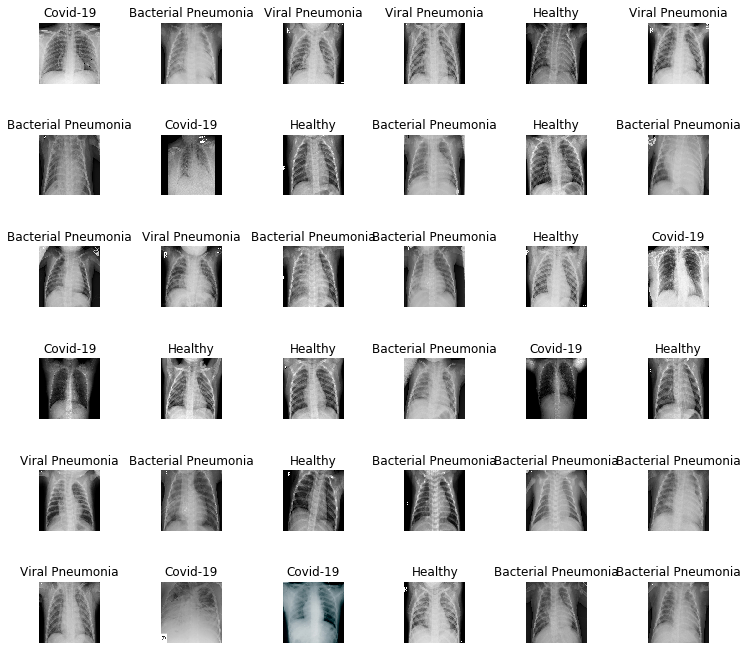

In [13]:
# Create a grid of 36 sample images along with their corresponding labels
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])]) # shows title and label_names
    axes[i].axis("off") # don't show # of pixels
    
plt.subplots_adjust(wspace = 1)

### Transfer learning

In [14]:
# Import pre-trained BASE model

basemodel = ResNet50(weights="imagenet", include_top = False, input_tensor=Input(shape=(256, 256, 3))) 

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\menfr\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [15]:
basemodel.summary() # model with 23Million parameters

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [16]:
# freezing the model upto the last stage -4 and re-training stage -5 
for layer in basemodel.layers[:-10]:
    layers.trainable = False

In [17]:
# Train our customized Model
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel) # I took the base model and added a pooling layer on top of it
headmodel = Flatten(name = "flatten")(headmodel) # added a flattened layer 
headmodel = Dense(256, activation = "relu")(headmodel) # added a dense fully connected layer with Relu activation function
headmodel = Dropout(0.3)(headmodel) # drop 20% of neurons to avoind co-dependency and overfitting
headmodel = Dense(256, activation = "relu")(headmodel) 
headmodel = Dropout(0.3)(headmodel) 
headmodel = Dense(4, activation = "softmax")(headmodel)  # classification on 4 outputs - softmax takes the higher prob value for the output.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
# combine the 2 models
model = Model(inputs = basemodel.input, outputs = headmodel)

In [19]:
# compile model
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-4), metrics = ['accuracy'])

In [20]:
# Use early stopping to avoid overfitting
# I am saving a separate training set data for validation and want to make sure that both losses go down. 
# When train loss decreases and vlaidation loss increases it means that the model is overfitting
# If train loss decreases and val loss increases, early stopping stops the training
earlystopping = EarlyStopping(monitor="val_loss", mode = 'min', patience=20) 

In [21]:
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True) 
# store weights of best model to be re-used. Save the best only with minimal validation loss

In [22]:
# for the training set
train_generator = image_gen.flow_from_directory(batch_size=4,  
                                                directory = df_directory, 
                                                shuffle = True,
                                               target_size = (256, 256),
                                               class_mode = "categorical",
                                               subset = "training")  #fetch images from directory

Found 428 images belonging to 4 classes.


In [23]:
# for the val set
val_generator = image_gen.flow_from_directory(batch_size=4,  
                                                directory = df_directory, 
                                                shuffle = True,
                                               target_size = (256, 256),
                                               class_mode = "categorical",
                                               subset = "validation")  #fetch images from directory

Found 104 images belonging to 4 classes.


In [24]:
# fit model to training data
import time
start = time.time()


history = model.fit_generator(train_generator, 
                              epochs=20, 
                              validation_data=val_generator, 
                              callbacks= [checkpointer, earlystopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
26/26 [==============================] - 25s 969ms/step - loss: 8.3795 - acc: 0.2500

Epoch 00001: val_loss improved from inf to 8.37947, saving model to weights.hdf5
107/107 [==============================] - 314s 3s/step - loss: 0.8683 - acc: 0.6963 - val_loss: 8.3795 - val_acc: 0.2500
Epoch 2/20
26/26 [==============================] - 24s 921ms/step - loss: 5.8741 - acc: 0.2500

Epoch 00002: val_loss improved from 8.37947 to 5.87407, saving model to weights.hdf5
107/107 [==============================] - 297s 3s/step - loss: 0.5048 - acc: 0.8481 - val_loss: 5.8741 - val_acc: 0.2500
Epoch 3/20
26/26 [==============================] - 24s 926ms/step - loss: 11.8913 - acc: 0.2500

Epoch 00003: val_loss did not improve from 5.87407
107/107 [==============================] - 296s 3s/step - loss: 0.2435 - acc: 0.9159 - val_loss: 11.8913 - val_acc: 0.2500
Epoch 4/20
26/26 [==============================] - 24s 921ms/step - loss: 5

In [25]:
end = time.time()
print((end-start)/60, "minutes")

99.75140880743662 minutes


In [27]:
# plot metrics of CNN
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

Text(0, 0.5, 'training accuracy and loss')

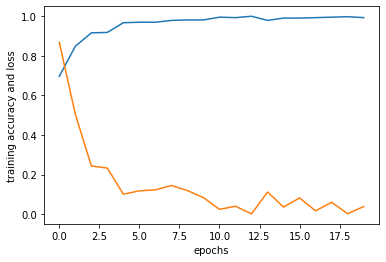

In [28]:
plt.plot(history.history["acc"]) # train set
plt.plot(history.history["loss"]) # train set
plt.xlabel("epochs")
plt.ylabel("training accuracy and loss")

Text(0, 0.5, 'validation loss')

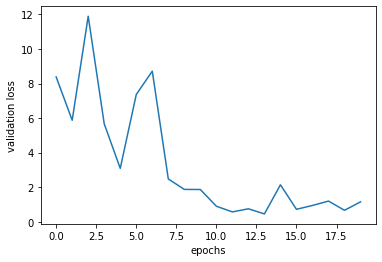

In [29]:
plt.plot(history.history["val_loss"]) # val set
plt.xlabel("epochs")
plt.ylabel("validation loss")

In [30]:
# test data
test_directory = "Covid19/Test"

In [31]:
test_gen = ImageDataGenerator(rescale = 1./255)

In [32]:
# grab the test images
test_generator = test_gen.flow_from_directory(batch_size=40, 
                                                directory = test_directory, 
                                                shuffle = True,
                                               target_size = (256, 256),
                                               class_mode = "categorical")
                                                 # no subcategory

Found 40 images belonging to 4 classes.


In [33]:
# Evaluate our model on test set
evaluate = model.evaluate_generator(test_generator, steps=test_generator.n//4, verbose = 1)

1/1 [==============================] - 10s 10s/step - loss: 2.3276 - acc: 0.8000


In [34]:
print("Accuracy test: {}".format(evaluate[1])) # shows accuracy of test set

Accuracy test: 0.800000011920929


In [40]:
# Predict image labels 

predictions = [] # predictions y_pred
original = [] # original test labels y_test
image = [] # images of y_test/y_pred

for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory,str(i))):
        img = cv2.imread(os.path.join(test_directory, str(i), item))
        img = cv2.resize(img, (256,256)) 
        image.append(img) # take each image from test folder, re-size it and append it to the list
        img = img / 255 # normalize image
        img = img.reshape(-1, 256,256,3) # reshape image, 3 channels
        predict = model.predict(img) # predict label by fitting test image to model
        predict =  np.argmax(predict) # get value of prediction
        predictions.append(predict)
        original.append(i) 
    

In [44]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

score = accuracy_score(original, predictions)
print("Test Accuracy: {}".format(score))

Test Accuracy: 0.8


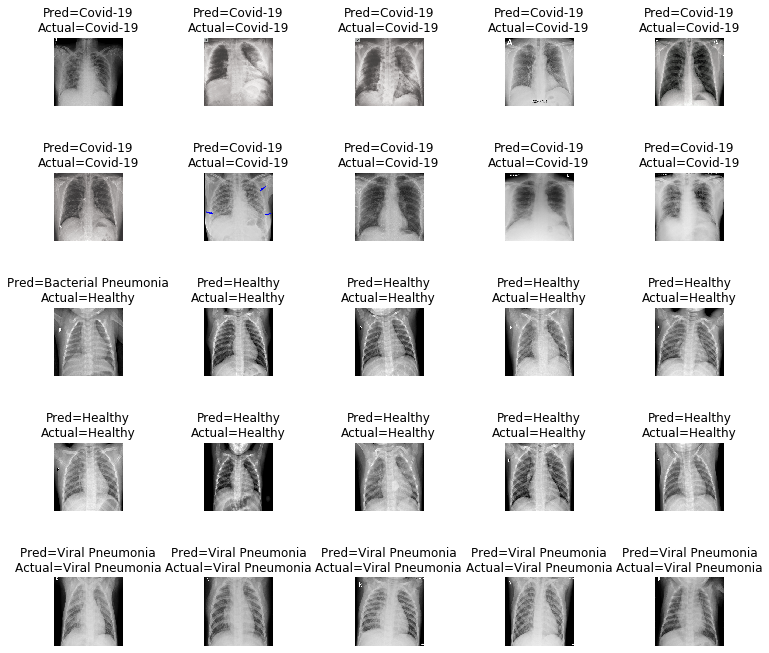

In [56]:
# Visualize some of the test images

L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Pred={}\nActual={}'.format(str(label_names[predictions[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2)

In [52]:
print(classification_report(np.asarray(original), np.asarray(predictions)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.64      0.90      0.75        10
           2       1.00      0.50      0.67        10
           3       0.80      0.80      0.80        10

    accuracy                           0.80        40
   macro avg       0.84      0.80      0.79        40
weighted avg       0.84      0.80      0.79        40



Text(0.5, 1, 'Confusion_matrix')

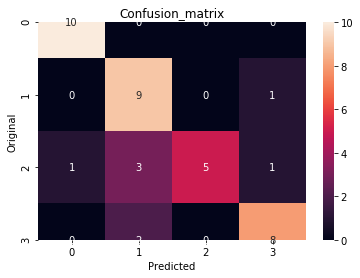

In [53]:
cm = confusion_matrix(np.asarray(original), np.asarray(predictions))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')